<a href="https://colab.research.google.com/github/vanithakattumuri/PAMI/blob/main/notebooks/highUtilityFrequentPatterns/basic/HUFIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding High Utility Frequent Patterns in Utility Databases using HUFIM

This tutorial has two parts. In the first part, we describe the basic approach to find High Utility Frequent Patterns in a Utility database using the HUFIM algorithm. In the final part, we describe an advanced approach, where we evaluate the HUFIM algorithm on a dataset at different minimum utility threshold values.
***

# Prerequisites:



1.   Installing the PAMI library

In [1]:
!pip install -U pami #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.0/835.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3313 sha256=64bc092210aaa34bc6c4e2953303d32caaa36ddbcdc02bfcb5b5d46d3bd11567
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4750 sha256=c365e64f463580544998266329ccdbe3a465bc9729644d6deb6370480ef5df6a
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully built JsonForm JsonSir


2.   Downloading a sample dataset

In [2]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/utilityDatabases/Utility_T10I4D100K.csv #download a sample utility database

--2023-09-06 16:48:15--  https://u-aizu.ac.jp/~udayrage/datasets/utilityDatabases/Utility_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.95.161.176, 150.31.244.160
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.95.161.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7356594 (7.0M) [text/csv]
Saving to: ‘Utility_T10I4D100K.csv’

Utility_T10I4D100K. 100%[===================>]   7.02M  1.52MB/s    in 8.2s    

2023-09-06 16:48:25 (877 KB/s) - ‘Utility_T10I4D100K.csv’ saved [7356594/7356594]



3.   Printing few lines of a dataset to know its format.

In [3]:
!head -2 Utility_T10I4D100K.csv

25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834:852:25	96	32	50	20	80	48	58	75	86	64	57	16	14	46	85 
39	120	124	205	401	581	704	814	825	834:396:6	60	42	58	31	53	10	52	22	62 


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Part 1: Finding High Utility Frequent Patterns using HUFIM

### Step 1: Understanding the statistics of a database to choose an appropriate minimum Support (minSup) value.

In [4]:
#import the class file
import PAMI.extras.dbStats.UtilityDatabase as stats

#specify the file name
inputFile = 'Utility_T10I4D100K.csv'

#initialize the class
obj=stats.UtilityDatabase(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99935
Total number of items : 870
Database sparsity : 0.9883886940304302
Minimum Transaction Size : 1
Average Transaction Size : 10.101836193525791
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667097909135199
Variance in Transaction Sizes : 13.447741640067324


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

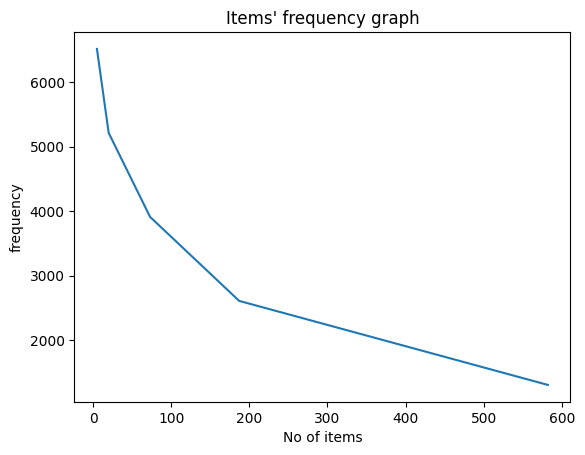

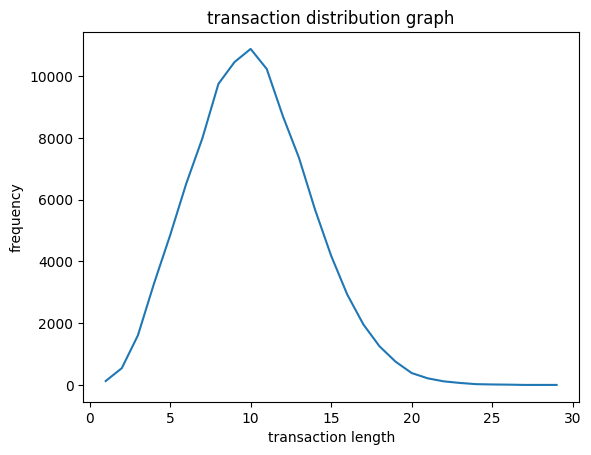

In [5]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, end = 100, title = 'Items\' frequency graph', xlabel = 'No of items', ylabel= 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, end = 100, title = 'transaction distribution graph', xlabel = 'transaction length', ylabel = 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 2000 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [6]:
minimumSupportCount = 2000    #minUtilCount is specified in count. However, the users can also specify minUtilCount between 0 and 1.
minUtilCount = 30000 # User can specify different value.

### Step 4: Mining High Utility Frequent Patterns using HUFIM

In [7]:
from PAMI.highUtilityFrequentPattern.basic import HUFIM  as alg #import the algorithm

obj = alg.HUFIM(iFile=inputFile, minUtil=minUtilCount, minSup=minimumSupportCount, sep='\t') #initialize
obj.startMine()            #start the mining process

obj.save('utilityFrequentPatternsAtMinSupCount2000.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

High Utility Frequent patterns were generated successfully using HUFIM algorithm
Total No of patterns: 155
Runtime: 38.390048027038574
Memory (RSS): 245485568
Memory (USS): 198893568


### Step 5: Investigating the generated patterns

Open the pattern's file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minUtil_ value.

In [8]:
!head 'utilityFrequentPatternsAtMinSupCount2000.txt'

368:389886:7821 
529:354693:7053 
829:344326:6802 
766:312711:6259 
722:293956:5839 
354:293525:5830 
684:270761:5404 
217:268340:5369 
494:258303:5097 
419:248584:5051 


The storage format is: _highUtilityFrequentPattern:support_
***

## Part 2: Evaluating the HUFIM algorithm on a dataset at different minSupCount values

### Step 1: Import the libraries and specify the input parameters

In [15]:
#Import the libraries
from PAMI.highUtilityFrequentPattern.basic import HUFIM  as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Utility_T10I4D100K.csv'
seperator='\t'
minUtilCount = 30000
minimumSupportCountList = [1000, 2000, 3000, 4000, 5000]
#minimumSupportCountList can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of HUFIM

In [16]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'minUtilCount', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of HUFIM algorithm

### Step 3: Execute the algorithm at different minSup values

In [17]:
for minSupCount in minimumSupportCountList:
    obj = alg.HUFIM(inputFile, minUtil=minUtilCount, minSup=minSupCount, sep=seperator)
    obj.startMine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['HUFIM', minSupCount, minUtilCount, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

High Utility Frequent patterns were generated successfully using HUFIM algorithm
High Utility Frequent patterns were generated successfully using HUFIM algorithm
High Utility Frequent patterns were generated successfully using HUFIM algorithm
High Utility Frequent patterns were generated successfully using HUFIM algorithm
High Utility Frequent patterns were generated successfully using HUFIM algorithm


### Step 4: Print the Result

In [18]:
print(result)

  algorithm  minSup  minUtilCount  patterns    runtime     memory
0     HUFIM    1000         30000       385  84.432577  251043840
1     HUFIM    2000         30000       155  48.828786  251015168
2     HUFIM    3000         30000        60  23.816722  253448192
3     HUFIM    4000         30000        26  12.281015  253448192
4     HUFIM    5000         30000        10  10.089041  253120512


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

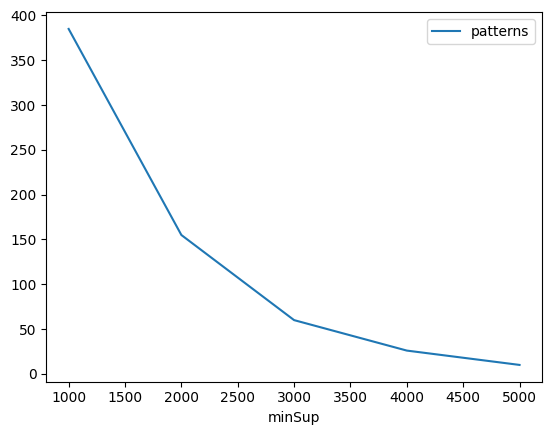

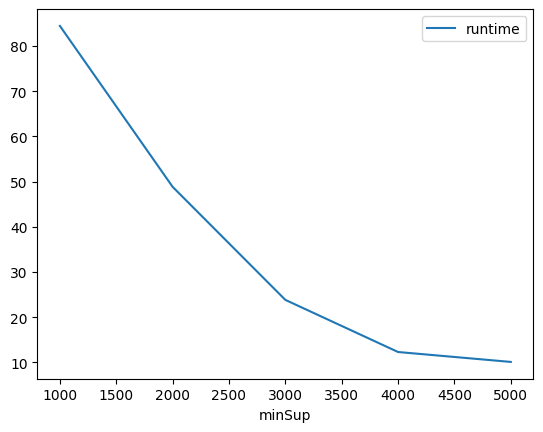

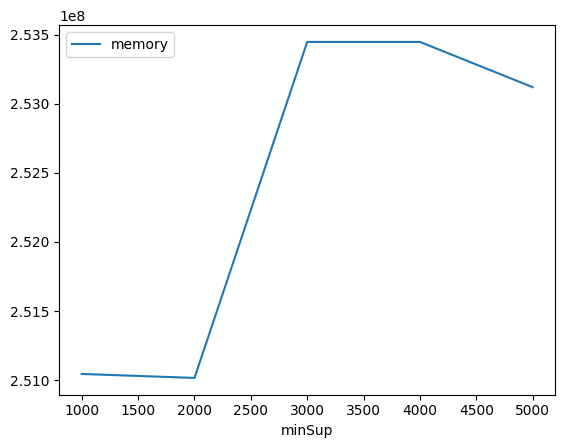

In [19]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib